In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import MD_AE_tools.mode_decomposition as md

import configparser

# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs


filename = "./data/PIV4_downsampled_by8.h5" # .h5 file of data
hf = h5py.File(filename,'r')
z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
hf.close()
ny = len(y)
nz = len(z)

In [ ]:
#=================== downsampled data ======================
filename = './data/PIV4_downsampled_by8.h5' # .h5 file of data
hf = h5py.File(filename,'r')
z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
vy = np.array(hf.get('vy'))
vz = np.array(hf.get('vz'))
hf.close()
print("Finished loading data.")
# print(vy.shape)
[nt,nz,ny] = vz.shape

vy = np.transpose(vy,[2,1,0])
vz = np.transpose(vz,[2,1,0]) #(ny,nz,nt)
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
print(X.shape)

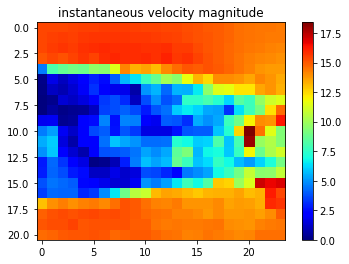

In [2]:
#===================== read from training ======================
results_folder = 'MD_10__2022_05_21__17_29_44'
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
folder = system_info['save_location'] + '/' + results_folder + '/'

filename = folder + 'results.h5'
hf = h5py.File('./data/training_data_1.h5','r')
# print(hf.keys())
u_test = np.array(hf.get('u_train'))[0,:,:,:,:]
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_avg = np.array(hf.get('u_mean_train'))# u_avg_test
hf.close()

[nt,ny,nz,nu] = u_test.shape

vy = u_test[:,:,:,0] + u_avg[:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = u_test[:,:,:,1] + u_avg[:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy))

V_test = (((u_test[:,:,:,0]+u_avg[:,:,0])**2)+((u_test[:,:,:,1]+u_avg[:,:,1])**2))**(0.5)
fig = plt.figure()
plt.imshow(V_test[0,:,:],'jet')
plt.colorbar()
plt.title('instantaneous velocity magnitude')
plt.show()

(21, 24, 1500)


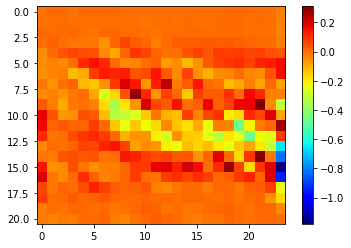

In [3]:
#=================== vorticity ========================
dy = y[1]-y[0]
dz = z[1]-z[0]

vz_plus = np.roll(vz,-1,axis=0) # w_j+1,k matrix
vz_plus[-1,:,:] = 2*vz[-1,:,:] # set new matrix(ny,k) to w(ny,k)
vz_plus[0,:,:] = 2*vz_plus[0,:,:]
vz_minus = np.roll(vz,1,axis=0) # w_j-1,k matrix
vz_minus[0,:,:] = 2*vz[0,:,:] # set new matrix(0,k) to w(0,k)
vz_minus[-1,:,:] = 2*vz_minus[-1,:,:]

vy_plus = np.roll(vz,-1,axis=1) # v_j,k+1
vy_plus[:,-1,:] = 2*vy[:,-1,:]
vy_plus[:,0,:] = 2*vy_plus[:,0,:]
vy_minus = np.roll(vz,1,axis=1) # v_l,k-1
vy_minus[:,0,:] = 2*vy[:,0,:]
vy_minus[:,-1,:] = 2*vy_minus[:,-1,:]

dwdy = (vz_plus - vz_minus)/(2*dy) # central difference
dvdz = (vy_plus - vy_minus)/(2*dz)

# vorticity = dwdy-dvdz
vor = dwdy - dvdz
print(vor.shape)

plt.figure()
plt.imshow(vor[:,:,0]-np.mean(vor,axis=-1),'jet')
plt.colorbar()
plt.show()

### Make gif of vorticity

In [ ]:
from matplotlib import animation

fps = 10
sec = 10
skip = 2
vor_plt = vor[:,:,::skip]
# vor_plt = np.abs(vor_plt)
print(vor_plt.shape)

fig_gif = plt.figure()
im = plt.imshow(vor_plt[:,:,0],vmin=-0.6,vmax=0.6,cmap='jet')
plt.colorbar()
plt.title('Vorticity')
plt.xticks([])
plt.yticks([])
plt.show()

def animation_func(i):
    im.set_array(vor_plt[:,:,i])
    return[im]

gif = animation.FuncAnimation(fig_gif,
                                animation_func,
                                frames=np.arange(fps*sec),
                                interval=1000/fps,
                                repeat=False)

gif.save('u_test_vorticity.gif',fps=fps)

### POD

Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


Text(0.5, 0, 'mode')

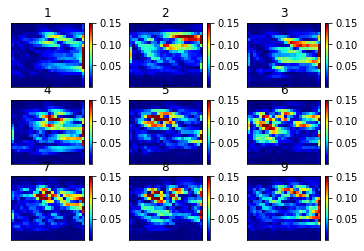

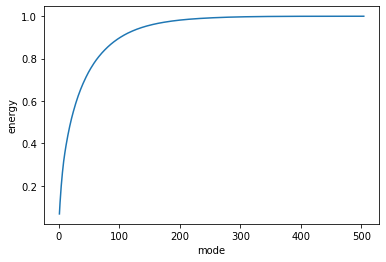

In [4]:
# vorticity
pod = md.POD(vor,method='classic')
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean

fig = plt.figure()

for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[ny,nz])
    plt.imshow(np.abs(pltV),'jet',vmax=0.15)
    plt.colorbar()

energy = np.cumsum(lam/np.sum(lam))
plt.figure()
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')

In [5]:
pod_v = md.POD(X,method='classic')
Q_POD_v,lam_v = pod_v.get_modes()
Q_mean_v = pod_v.Q_mean

Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


In [6]:
lam_v[:5]

array([225.25334186, 140.47556589,  91.54630165,  90.01046577,
        70.96155792])

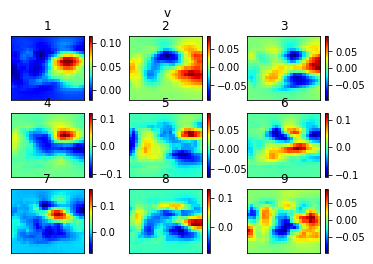

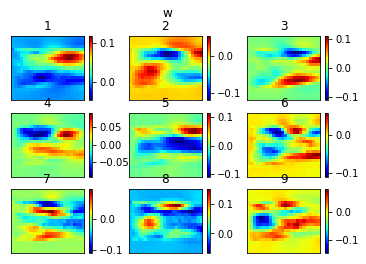

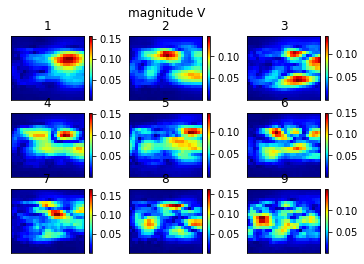

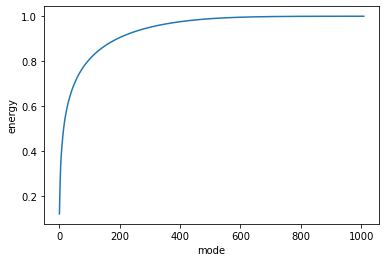

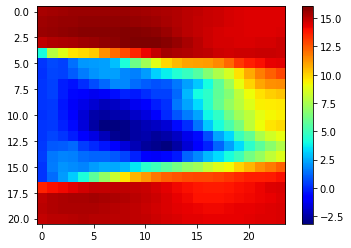

In [7]:
plt.figure()
plt.suptitle('v')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = pltV[ny:,:]
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

plt.figure()
plt.suptitle('w')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = pltV[0:ny,:]
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

plt.figure()
plt.suptitle('magnitude V')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = (pltV[0:ny,:]**2 + pltV[ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

energy = np.cumsum(lam_v/np.sum(lam_v))
plt.figure()
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')

## Reconstruct
PlotWhichVelocity = 'w'
rebuildv = pod_v.reconstruct(number_of_modes=10,shape=[2,ny,nz,nt])
if PlotWhichVelocity == 'w': # Q was built [vz,vy]
    rebuildv = rebuildv[0,:,:,0]
elif PlotWhichVelocity == 'v':
    rebuildv = rebuildv[1,:,:,0]
elif PlotWhichVelocity =='V':
    rebuildv = (rebuildv[0,:,:,0]**2 + rebuildv[1,:,:,0]**2)**0.5
plt.figure()
plt.imshow(rebuildv,'jet')#-(np.sum(u_avg**2,axis=-1)**0.5)
plt.colorbar()
plt.show()

In [8]:
a = pod_v.reconstruct(number_of_modes=5,shape=[2,ny,nz,nt])
a = np.transpose(a,[3,1,2,0])
c = []
c.append(a[:,:,:,1])
c.append(a[:,:,:,0])
c = np.transpose(c,[1,2,3,0])
print(c.shape)
b = u_test+u_avg

(1500, 21, 24, 2)


In [9]:
np.mean((b - c)**2)

1.245144200610789

In [10]:
print(np.sum(lam_v[:10]))
print(energy[9])

813.162694023005
0.4338742308637589
